In [ ]:
################# importing all necessary packages
!pip install catboost
import pandas as pd
import numpy as np
from sklearn import metrics
import itertools
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import scipy.stats
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import seaborn as sns
from matplotlib import cm, pyplot as plt
from scipy import stats as st
from sklearn.utils import resample
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import pandas as pd
import numpy as np
import itertools
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import scipy.stats
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import seaborn as sns
from matplotlib import cm, pyplot as plt
from scipy import stats as st
from sklearn.utils import resample
sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



Feature Engineering

In [ ]:
import pandas as pd
def load_data(asset, level):
    ### load the input quote file in this format
    data = pd.read_csv('{0}_orderbookk_{1}.csv'.format(asset, level), header=None)
    levels = list(range(1, level + 1))
    iters = [iter(levels), iter(levels), iter(levels), iter(levels)]
    abv = ['ask', 'volume_ask', 'bid', 'volume_bid'] * level
    nums = [x for x in itertools.chain.from_iterable(itertools.zip_longest(levels, levels, levels, levels)) if x]
    data.columns = list(map(lambda x, y: '{0}_{1}'.format(x, y), abv, nums))
    
    return data   

def feature_engineering(ds, level, num_lags):
    out_df = pd.DataFrame()
    
    for i in range(1, level + 1):
        out_df['log_return_ask_{0}'.format(i)] = np.log(ds['ask_{0}'.format(i)].pct_change() + 1)
        out_df['log_return_bid_{0}'.format(i)] = np.log(ds['bid_{0}'.format(i)].pct_change() + 1)
        out_df['log_ask_{0}_div_bid_{0}'.format(i)] = np.log(ds['ask_{0}'.format(i)] / ds['bid_{0}'.format(i)])
        out_df['log_volume_ask_{0}_div_bid_{0}'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)] / ds['volume_bid_{0}'.format(i)])
        
        out_df['log_volume_ask_{0}'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)])
        out_df['log_volume_bid_{0}'.format(i)] = np.log(ds['volume_bid_{0}'.format(i)])
        
        if i != 1:
            out_df['log_ask_{0}_div_ask_1'.format(i)] = np.log(ds['ask_{0}'.format(i)] / ds['ask_1'])
            out_df['log_bid_{0}_div_bid_1'.format(i)] = np.log(ds['bid_{0}'.format(i)] / ds['bid_1'])
            out_df['log_volume_ask_{0}_div_ask_1'.format(i)] = np.log(ds['volume_ask_{0}'.format(i)] / ds['volume_ask_1'])
            out_df['log_volume_bid_{0}_div_bid_1'.format(i)] = np.log(ds['volume_bid_{0}'.format(i)] / ds['volume_bid_1'])
        
    out_df['log_total_volume_ask'] = np.log(ds[['volume_ask_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
    out_df['log_total_volume_bid'] = np.log(ds[['volume_bid_{0}'.format(x) for x in list(range(1, level + 1))]].sum(axis = 1))
            
    mid_price = (ds['ask_1'] + ds['bid_1']) / 2
    out_df['log_return_mid_price'] = np.log(mid_price.pct_change() + 1).shift(-1)
        
    cols_features = out_df.columns.drop(target_column)
    out_df = out_df.assign(**{
        '{}_(t-{})'.format(col, t): out_df[col].shift(t)
        for t in list(range(1, num_lags))
        for col in cols_features})
    
    return out_df.dropna()

We will take the target column to predict is log_return_mid_price



In [ ]:
target_column = 'log_return_mid_price'

### Plotting the features against time




In [ ]:
import itertools  
import numpy as np
source_data = load_data('AAPL', 1)
dataset = feature_engineering(source_data, 1, 1)

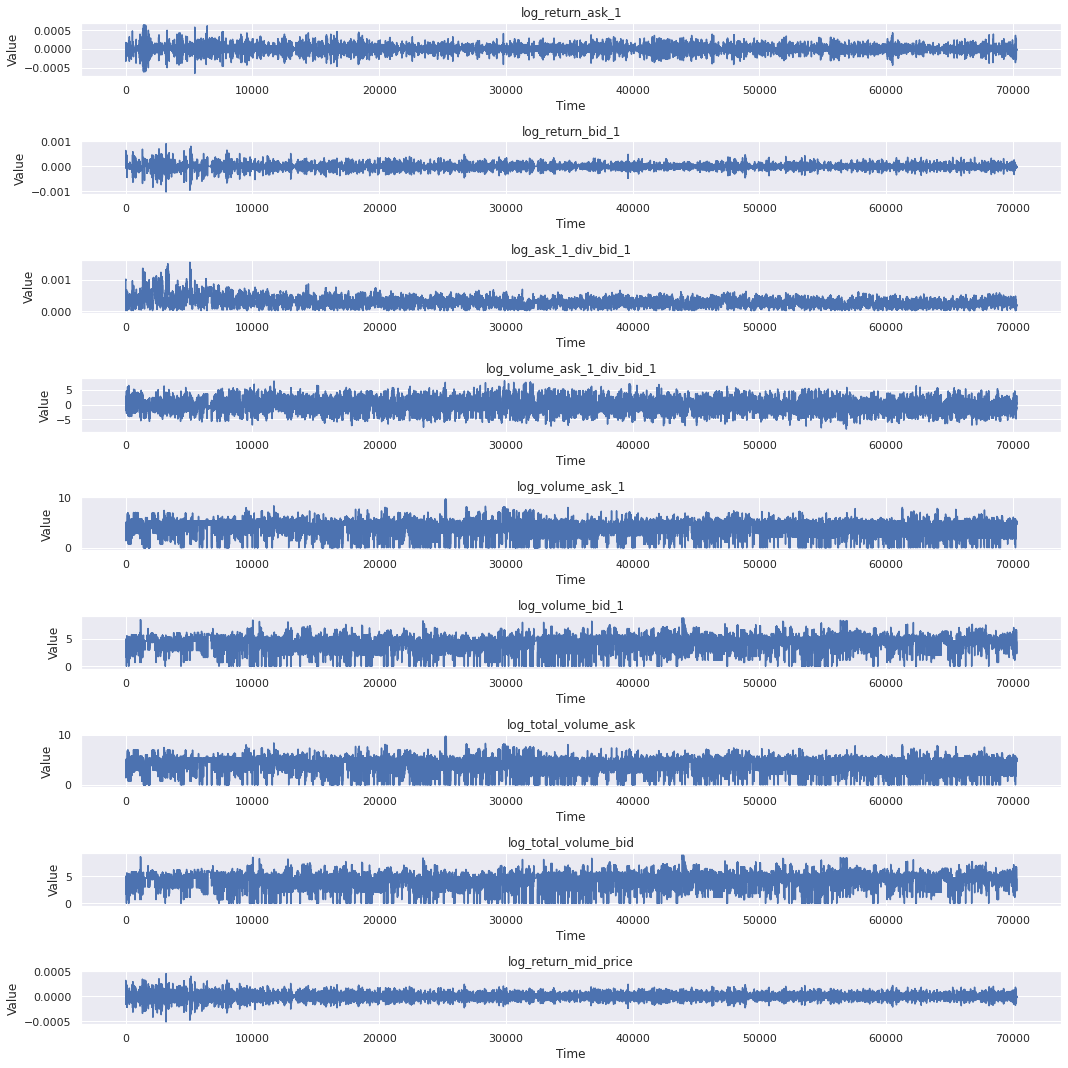

In [ ]:
from matplotlib import cm, pyplot as plt
fig, axs = plt.subplots(len(dataset.columns), 1, figsize = (15, 15))
for i in range(0, len(dataset.columns)):
    c = dataset.columns[i]
    
    axs[i].plot(dataset[c])
    axs[i].set_title(c)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
plt.tight_layout()
plt.show()

### Training advanced ML model - Gradient boosting algorithms (Adaboost and catboost)


bs_interval - the function that carries out the estimation of bootstrapped interval of errors.

do_experiment - splitting data and train/test model on it

In [ ]:
def bs_interval(arr, num_bs_size = 10000, num_elements_mean = 1000, alpha = 0.05):
    bs = list()
    for i in range(0, num_bs_size):
        bs.append(np.mean(resample(arr, n_samples = num_elements_mean)))
        
    return st.t.interval(1 - alpha, len(bs) - 1, loc = np.mean(bs), scale = st.sem(bs))

def objective(hyper_params):
    print(hyper_params)
    source_data = load_data(hyper_params['asset_name'], hyper_params['level'])
    dataset = feature_engineering(source_data, hyper_params['level'], int(hyper_params['num_lags']))
    
    start_valid_ind = int(dataset.shape[0] * 0.5)
    start_test_ind = int(dataset.shape[0] * 0.75)
    train_ds = dataset[:start_valid_ind]
    valid_ds = dataset[start_valid_ind:start_test_ind]
    ############# Catbost hyperpaarameters and fitting model
    regr = CatBoostRegressor(n_estimators = hyper_params['n_estimators'], thread_count=3, task_type = 'CPU',
                             learning_rate = hyper_params['learning_rate'], depth = hyper_params['depth'],
                             l2_leaf_reg = hyper_params['l2_leaf_reg'], loss_function = 'RMSE')
    
    regr.fit(train_ds[train_ds.columns.drop(target_column)], train_ds[target_column],
             use_best_model = True, logging_level = 'Silent',
             eval_set = (valid_ds[valid_ds.columns.drop(target_column)], valid_ds[target_column]))

    predictions = regr.predict(valid_ds[valid_ds.columns.drop(target_column)])
    result = mean_squared_error(valid_ds[target_column], predictions)
    
    print('Objective function value on validation set: ' + str(result))
    return result

def do_experiment(asset_name):
    levels = [1]
    const_params = {'asset_name': asset_name}
    hyper_params_space = {'level': hp.choice('level', levels),
                          'num_lags': hp.quniform('num_lags', 1, 10, 1),
                          'n_estimators': hp.quniform('n_estimators', 50, 500, 5),
                          'depth': hp.quniform('depth', 1, 10, 1),
                          'learning_rate': hp.uniform('learning_rate', 0.05, 1.0),
                          'l2_leaf_reg':  hp.uniform('l2_leaf_reg', 0.01, 30.0)}
    
    hyper_params_space.update(const_params)
    tpe_trials = Trials()
    opt_params = fmin(
        fn = objective,
        space = hyper_params_space,
        algo = tpe.suggest,
        max_evals = 30,
        trials = tpe_trials,
        rstate = np.random.RandomState(100))
    
    opt_params.update(const_params)
    opt_params['level'] = levels[opt_params['level']]
    print('Best parameters:')
    print(opt_params)
    
    source_data = load_data(asset_name, opt_params['level'])
    print('Input data shape is {0}'.format(source_data.shape))
    print(source_data.head())
    
    dataset = feature_engineering(source_data, opt_params['level'], int(opt_params['num_lags']))
    print('Dataset shape is {0}'.format(dataset.shape))
    print(dataset.head())
    start_test_ind = int(dataset.shape[0] * 0.75)
    train_ds = dataset[:start_test_ind]
    test_ds = dataset[start_test_ind:]

    #AdaBoostRegressor - Uncomment to run adaboost regressor
   # regr = AdaBoostRegressor(n_estimators = 50, learning_rate = opt_params['learning_rate'], loss = 'exponential')
    regr = CatBoostRegressor(n_estimators = opt_params['n_estimators'], thread_count=3, task_type = 'CPU',
                             learning_rate = opt_params['learning_rate'], depth = opt_params['depth'],
                             l2_leaf_reg = opt_params['l2_leaf_reg'], loss_function = 'RMSE')
    regr.fit(train_ds[train_ds.columns.drop(target_column)], train_ds[target_column], use_best_model = False, logging_level = 'Silent')
    ### below fitting is for adaboost regressor
  #  regr.fit(train_ds[train_ds.columns.drop(target_column)], train_ds[target_column])
   
    print("regressor:")
    fi = pd.DataFrame({'feature': regr.feature_names_, 'importance': regr.feature_importances_})
    plt.figure(figsize=(15, 10))
    plt.barh(fi.feature, fi.importance)
    ############## printing the important features for the model
    plt.title('Feature importances')
    plt.show()
    print('Feature importances table:')
    print(fi.sort_values('importance', ascending = False))
    
    predictions = regr.predict(test_ds[test_ds.columns.drop(target_column)])
    ##### Print a list of predicted values
    print("predictions")
    print(list(predictions))
    #plt.plot(list(predictions), color='green', marker='o',mfc='pink' ) #plot the data
  #  plt.xticks(range(0,len(list(predictions)+1, 1)) )#set the tick frequency on x-axis
    #### printing a list of true or target midprice returns
    print(list(test_ds[target_column]))
    #### We want to plot a midprice return but differencing them over the interval will show peaks/pointers where the midprice drifted
    ret1= np.diff(list(predictions))
    plt.plot(ret1, color='magenta', marker='o',mfc='pink' ) #plot the data
    plt.xticks(range(0,len(ret1)+1, 1)) #set the tick frequency on x-axis
    plt.ylabel('predicted midprice returns drift') #set the label for y axis
    plt.xlabel('index') #set the label for x-axis
    plt.title("Midprice drift") #set the title of the graph
    plt.show() #display the graph

   
   
    baseline_mse = np.array((test_ds[target_column] - np.zeros_like(test_ds[target_column])) ** 2)
    modeling_mse = np.array((test_ds[target_column] - predictions) ** 2)
    
    print('MSE on test set: ' + str(mean_squared_error(test_ds[target_column], predictions)))
    print('r2 score : ' + str(r2_score(test_ds[target_column], predictions)))
   
    print('Confidence interval of MSE for baseline: ' + str(bs_interval(baseline_mse)))
    print('Confidence interval of MSE for modeling: ' + str(bs_interval(modeling_mse)))
    
    plt.figure(figsize=(15, 10))
    plt.scatter(test_ds[target_column],  predictions)
    ### trying to fit a linear best fit line
    m, b = np.polyfit(test_ds[target_column], predictions, 1)
    plt.plot(test_ds[target_column], m*test_ds[target_column]+b, color='green')

   # p1 = max(max(predictions), max(test_ds[target_column]))
   # p2 = min(min(predictions), min(test_ds[target_column]))
   # plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Returns', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
   # plt.axis('equal')
    plt.show()
   # x_ax = range(len(test_ds[target_column]))
   # plt.scatter(x_ax, test_ds[target_column], s=5, color="blue", label="True returns")
   # plt.plot(x_ax, predictions, lw=0.8, color="red", label="predicted")
  #  plt.scatter(test_ds[target_column], predictions, c='red')
  #  plt.title('True returns and Predictions scatter plot')
  #  plt.xlabel('True returns')
  #  plt.ylabel('Predictions')
  #  plt.show()

{'asset_name': 'AAPL', 'depth': 10.0, 'l2_leaf_reg': 12.720471328608813, 'learning_rate': 0.9666961318684093, 'level': 1, 'n_estimators': 160.0, 'num_lags': 4.0}
Objective function value on validation set: 9.309407709040571e-10
{'asset_name': 'AAPL', 'depth': 9.0, 'l2_leaf_reg': 3.7646323178779584, 'learning_rate': 0.42535172238290203, 'level': 1, 'n_estimators': 125.0, 'num_lags': 5.0}
Objective function value on validation set: 9.004146737925552e-10
{'asset_name': 'AAPL', 'depth': 6.0, 'l2_leaf_reg': 23.61898810294954, 'learning_rate': 0.7522995037165711, 'level': 1, 'n_estimators': 235.0, 'num_lags': 4.0}
Objective function value on validation set: 9.028590775417509e-10
{'asset_name': 'AAPL', 'depth': 4.0, 'l2_leaf_reg': 21.12832618095778, 'learning_rate': 0.783250597526508, 'level': 1, 'n_estimators': 295.0, 'num_lags': 5.0}
Objective function value on validation set: 9.128653963408532e-10
{'asset_name': 'AAPL', 'depth': 5.0, 'l2_leaf_reg': 4.439875710828954, 'learning_rate': 0.586

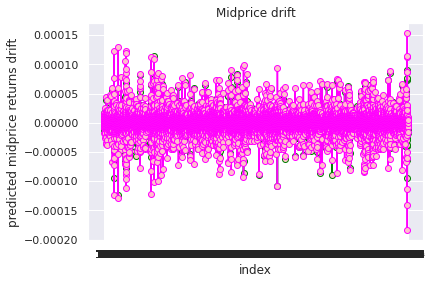

MSE on test set: 7.209716895849882e-10
r2 score : 0.0983476442098391
Confidence interval of MSE for baseline: (7.973992695579369e-10, 8.006242856837788e-10)
Confidence interval of MSE for modeling: (7.193429300519374e-10, 7.220934885643023e-10)


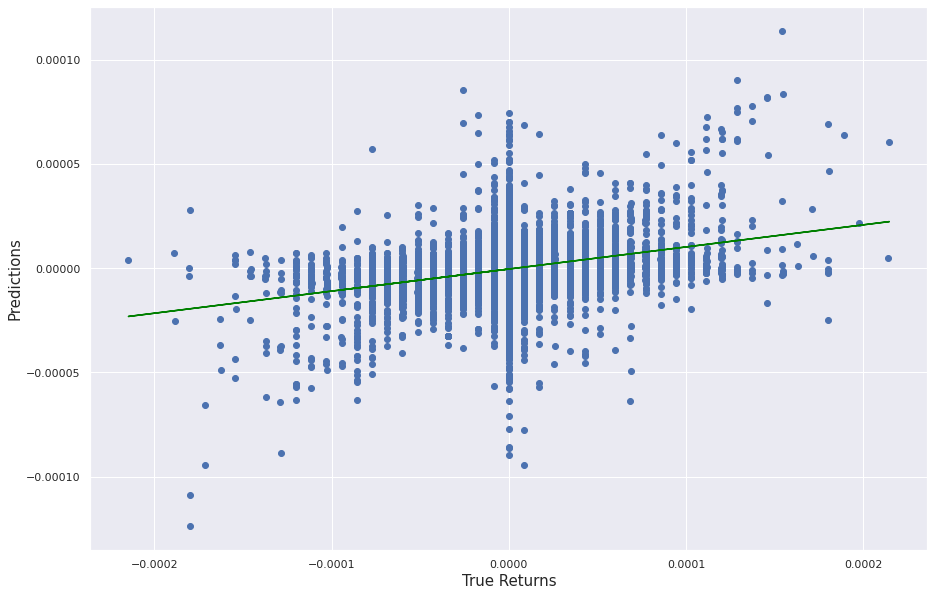

In [ ]:







import pandas as pd
import numpy as np
import itertools
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error , r2_score
#from sklearn.metrics import accuracy_score
import scipy.stats
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import seaborn as sns

from matplotlib import cm, pyplot as plt
from scipy import stats as st
from sklearn.utils import resample
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
do_experiment('AAPL')